# Ray Concepts - Task Parallelism (Part 2)

The previous lesson explored Ray's core concepts and how they work. We learned how to define Ray _tasks_, run them, and retrieve the results. We  also started learning about how Ray schedules tasks in a distributed environment.

This lesson completes the discussion of Ray tasks by exploring how task dependencies are handled. We'll also look under the hood at Ray's architecture and runtime behavior.

> **Tip:** Recall that the [Ray Package Reference](https://ray.readthedocs.io/en/latest/package-ref.html) in the [Ray Docs](https://ray.readthedocs.io/en/latest/) is useful for exploring the API features we'll learn.

In [1]:
# Imports and initialize Ray. We're adding NumPy for the examples and the tutorial `util` library:

import ray, time, sys    # New notebook, so new process
import numpy as np       # Used for examples
sys.path.append('..')    # Import our own libraries starting in the project root directory

from util.printing import pnd, pd

In [2]:
ray.init(ignore_reinit_error=True)

2020-04-07 10:31:13,818	INFO resource_spec.py:204 -- Starting Ray with 5.76 GiB memory available for workers and up to 2.9 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-07 10:31:14,158	INFO services.py:1146 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.149',
 'redis_address': '192.168.1.149:41516',
 'object_store_address': '/tmp/ray/session_2020-04-07_10-31-13_811695_72091/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-07_10-31-13_811695_72091/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-07_10-31-13_811695_72091'}

Let's work with a new remote function. Previously, our `expensive` and `expensive_task` functions returned tuples that included time durations. Obviously the durations were useful for understanding how long the functions took to execute. Now, it will be more convenient to not return "metadata" like this, but just data values that we care about, because we are going to pass them to other functions. 

Hence, we'll define _dependentcy_ relationships between tasks. We'll learn how Ray handles these dependent, asynchronous computations.

So, let's define a task to return a random NumPy array of some size `n`. As before, we'll add a sleep time, one tenth the size of `n`:

In [3]:
@ray.remote
def make_array(n):
    time.sleep(n/10.0)
    return np.random.standard_normal(n)

Now define a task that can add two NumPy arrays together. The arrays need to be the same size, but we'll ignore any checking for this requirement.

In [4]:
@ray.remote
def add_arrays(a1, a2):
    time.sleep(a1.size/10.0)
    return np.add(a1, a2)

Now lets use them!

In [5]:
start = time.time()
id1 = make_array.remote(20)
id2 = make_array.remote(20)
id3 = add_arrays.remote(id1, id2)
print(ray.get(id3))
pd(time.time() - start, prefix="Total time:")

[-0.92900629  0.28904398 -1.07096964 -2.5296009   1.50764446  2.4188372
 -0.85552723 -0.75164429  0.20511419  1.51509312 -1.26188206  0.41259856
  1.87627381  0.39031787 -0.30669317  0.00659595  1.53900995  0.70826332
 -0.38235873  0.7622296 ]
Total time: duration:  4.024 seconds


Something subtle and "magical" happened here; when we called `add_arrays`, we didn't need to call `ray.get()` first for `id1` and `id2`, since `add_arrays` expects NumPy arrays. Because `add_arrays` is a Ray task, Ray automatically does the extraction for us, so we can write code that looks more natural.

Furthermore, note that the `add_arrays` task effectively depends on the outputs of the two `make_array` tasks. Ray won't run `add_arrays` until the other tasks are finished. Hence, _Ray handles task dependencies automatically for us._ 

This is why the elapsed time is about 4 seconds. We used a size of 20, so we slept 2 seconds in each call to `make_array`, but those happened in parallel, _followed_ by a second sleep of 2 seconds in `add_arrays`.

Recall from the previous lesson that we explored when to call `ray.get()` to avoid forcing tasks to become synchronous when they should be asynchronous. This additional example illustrates two key points:

* _Don't ask for results you don't need._
* _Don't ask for the results you need until you really need them._

We don't need to see the objects for `id1` and `id2`. We only need the final array for `id3`.

## Using ray.wait() with ray.get()

We've seen several examples of the best idiomatic way to use `ray.get()`. Here again is an example from the last lesson:

```python
start = time.time()
ids = [expensive_task.remote(n) for n in range(5)]  # Fire off the asynchronous tasks
for n2, duration in ray.get(ids):                   # Retrieve all the values from the list of futures
    p(n2, duration)
pd(time.time() - start, prefix="Total time:")
```

Let's try it again with our new methods:

In [6]:
start = time.time()
array_ids = [make_array.remote(n*10) for n in range(5)]
added_array_ids = [add_arrays.remote(id, id) for id in array_ids]
for array in ray.get(added_array_ids):
    print(f'{array.size}: {array}')
pd(time.time() - start, prefix="Total time:")

0: []
10: [-1.28521667  1.26558629  2.39937045 -1.51618858 -0.63292281  1.21087438
  0.4026137  -0.13121685  1.25820152 -0.25434667]
20: [-2.96502132  0.43833885  3.39653803  1.84590608  0.97448447  0.17863497
 -2.76859471  1.13233276  0.40424164  3.24151925  1.47777294 -0.44786472
  0.04608181  0.07562737 -0.92047336  0.1449865   0.73483947 -0.73677343
 -0.23823027 -3.9818802 ]
30: [ 1.52497016  0.55501739  0.38781228  2.15907634  1.90902178 -4.7781606
  3.75800758  3.99353092  2.13657905 -1.44246518 -1.45340331 -2.50227053
  5.02785726 -0.30112174 -1.34993663  1.30102372  0.51863938 -1.32379222
  0.360588    0.08009505 -1.69305149 -2.89418832 -0.8262835  -2.20247908
 -1.03967996 -2.68040573  2.86863223 -1.65785085  0.14207972  2.78305   ]
40: [ 1.39202784 -0.28546437 -1.33538397 -1.20455682  3.62194578 -4.2478989
 -3.43274135 -0.65863866 -0.96586936 -1.26179936  2.4455379  -0.62949832
  1.38512699  2.52576169 -0.99245834  0.01076307 -0.55646388  0.18512492
 -2.80733186 -2.62947634  0

On my machine, I waited 8 seconds and then everything was printed at once.

There are two fundamental problems with the way we've used `ray.get()` so far:

1. There's no timeout, in case something gets "hung".
2. We have to wait for _all_ the objects to be available before `ray.get()` returns.

The ability to specify a timeout is essential in production code as a defensive measure. Many potential problems could happen in a real production system, any one of which could cause the task we're waiting on to take an abnormally long time to complete or never complete. Our application would be deadlocked waiting on this task. Hence, it's **strongly recommended** in production software to always use timeouts on blocking calls, so that the application can attempt some sort of recovery in situations like this, or at least report the error and "degrade gracefully".

Actually, there _is_ a `timeout=<value>` option you can pass to `ray.get()` ([documentation](https://ray.readthedocs.io/en/latest/package-ref.html#ray.get)), but it will most likely be removed in a future release of Ray. Why remove it if timeouts are important? This change will simplify the implementation of `ray.get()` and encourage the use of `ray.wait()` for waiting ([documentation](https://ray.readthedocs.io/en/latest/package-ref.html#ray.wait)) instead, followed by using `ray.get()` to retrieve values for tasks that `ray.wait()` tells us are finished. 

Using `ray.wait()` is also the way to fix the second problem with using `ray.get()` by itself, that we have to wait for all tasks to finish before we get any values back. Some of those tasks might finish quickly, like our contrived examples that sleep for short durations compared to other invocations. 

When you have a list of asynchronous tasks, you want to process the results of them as soon they become available, even while others continue to run. Use `ray.wait()` for this purpose.

Therefore, while `ray.get()` is simple and convenient, for _production code_, we recommend using `ray.wait()`, **with** timeouts, for blocking on running tasks. Then use `ray.get()` to retrieve values of completed tasks. Now we'll learn how to use these two together. For a longer discussion on `ray.wait()`, see [this blog post](https://medium.com/distributed-computing-with-ray/ray-tips-and-tricks-part-i-ray-wait-9ed7a0b9836d).

Here is the previous example rewritten to use `ray.wait()`:

In [7]:
start = time.time()
array_ids = [make_array.remote(n*10) for n in range(5)]
added_array_ids = [add_arrays.remote(id, id) for id in array_ids]

arrays = []
waiting_ids = list(added_array_ids)        # Assign a working list to the full list of ids
while len(waiting_ids) > 0:                # Loop until all tasks have completed
    # Call ray.wait with:
    #   1. the list of ids we're still waiting to complete,
    #   2. tell it to return immediately as soon as one of them completes,
    #   3. tell it wait up to 10 seconds before timing out.
    ready_ids, remaining_ids = ray.wait(waiting_ids, num_returns=1, timeout=10.0)
    print('Returned {:3d} completed tasks. (elapsed time: {:6.3f})'.format(len(ready_ids), time.time() - start))
    new_arrays = ray.get(ready_ids)
    arrays.extend(new_arrays)
    for array in new_arrays:
        print(f'{array.size}: {array}')
    waiting_ids = remaining_ids  # Reset this list; don't include the completed ids in the list again!
    
print(f"\nall arrays: {arrays}")
pd(time.time() - start, prefix="Total time:")

Returned   1 completed tasks. (elapsed time:  0.006)
0: []
Returned   1 completed tasks. (elapsed time:  2.012)
10: [ 4.37754862 -1.02590609 -1.68254241  2.33495923  3.54804578  0.35393678
 -0.54709416 -2.17506922  1.22213426 -2.37065039]
Returned   1 completed tasks. (elapsed time:  4.008)
20: [ 1.56663724 -2.34833082  1.59149292 -0.33014161 -1.02004453  2.87469325
 -4.16367098  1.04141674  0.50473669  2.50781868  2.23925251 -3.12342622
 -1.69920683 -0.14504243  0.81697685 -0.70844537 -1.09033079 -1.07665526
  2.43589054 -1.47329542]
Returned   1 completed tasks. (elapsed time:  6.011)
30: [-0.85774983 -1.13884571 -0.25658309 -1.18223521  1.4843025   0.06712266
 -2.19242163 -2.16328539 -1.61968612  0.43222729 -0.17777361  0.91608206
  2.81284324  0.48293915 -0.49168513 -1.45702508  1.58489628  1.19219043
  1.57105747 -4.22667127  1.59453551  1.46912239 -3.45294313 -1.91154354
  0.06362904 -2.04744221  0.76687402 -0.00997488  2.60191129 -2.16324354]
Returned   1 completed tasks. (elaps

Now it still takes about 8 seconds to complete, 4 seconds for the longest invocation of `make_array` and 4 seconds for the invocation of `add_arrays`, but since the others complete more quickly, we see their results as soon as they become available, at 0, 2, 4, and 6 second intervals.

> **Warning:** For each call to `ray.wait()` in a loop like this, it's important to remove the ids that have completed. Otherwise, `ray.wait()` will return immediately with the same list containg the first completed item, over and over again; you'll loop forever!! Resetting the list is easy, since the second list returned by `ray.wait()` is the rest of the items that are still running. So, that's what we use.

Now let's try it with `num_returns = 2`:

In [8]:
start = time.time()
array_ids = [make_array.remote(n*10) for n in range(5)]
added_array_ids = [add_arrays.remote(id, id) for id in array_ids]

arrays = []
waiting_ids = list(added_array_ids)        # Assign a working list to the full list of ids
while len(waiting_ids) > 0:                # Loop until all tasks have completed
    # Call ray.wait with:
    #   1. the list of ids we're still waiting to complete,
    #   2. tell it to return immediately as soon as TWO of them complete,
    #   3. tell it wait up to 10 seconds before timing out.
    return_n = 2 if len(waiting_ids) > 1 else 1
    ready_ids, remaining_ids = ray.wait(waiting_ids, num_returns=return_n, timeout=10.0)
    print('Returned {:3d} completed tasks. (elapsed time: {:6.3f})'.format(len(ready_ids), time.time() - start))
    new_arrays = ray.get(ready_ids)
    arrays.extend(new_arrays)
    for array in new_arrays:
        print(f'{array.size}: {array}')
    waiting_ids = remaining_ids  # Reset this list; don't include the completed ids in the list again!
    
print(f"\nall arrays: {arrays}")
pd(time.time() - start, prefix="Total time:")

Returned   2 completed tasks. (elapsed time:  2.011)
0: []
10: [ 2.32587808  0.82081304  2.9989117  -1.33997147 -0.26643259  1.22837907
  1.53030884  1.06810398  0.47756821  0.08559873]
Returned   2 completed tasks. (elapsed time:  6.009)
20: [ 0.04686546  1.01922614 -3.96177706 -5.07743723  1.59315458 -1.72849098
 -4.1063426  -3.62077657  3.64399788  1.36173483 -1.73825402 -2.78345861
  0.84605929  1.14917603  3.00051432  0.71238277  4.0761519  -2.88021332
  1.5112388   1.27605218]
30: [ 0.24564884 -3.2056104  -2.02551124  1.34561076  0.92004979  0.35295672
 -0.5291997  -0.35103231 -1.90190146 -0.69428032 -1.52584985 -0.08200455
  0.68416971  1.43915754 -0.45470125  0.5556991   3.37083264 -0.57751254
  2.09951144  0.90027113 -1.69638456 -2.18414622  0.46947156 -0.11223115
  0.73788965 -1.87241626  0.52417064 -0.206582    3.12787474  1.34327805]
Returned   1 completed tasks. (elapsed time:  8.015)
40: [-0.49855643  0.06036861  0.85994166  3.42091071 -5.12520426 -0.40020654
  5.31167768

Now we get two at a time output. Note that we don't actually pass `num_returns=2` every time. If you ask for more items than the length of the input list, you get an error. So, we compute `num_returns`, using `2` except when there's only one task to wait on, in which case we use `1`. So, in fact, the output for `40` was a single task result, because we started with `5` and processed two at a time.

## Exercise 2

The following cell is identical to the last one. Modify it to use a timeout of `2.5` seconds, shorter than our longest tasks. What happens now? Try using other times.

In [ ]:
start = time.time()
array_ids = [make_array.remote(n*10) for n in range(5)]
added_array_ids = [add_arrays.remote(id, id) for id in array_ids]

arrays = []
waiting_ids = list(added_array_ids)        # Assign a working list to the full list of ids
while len(waiting_ids) > 0:                # Loop until all tasks have completed
    # Call ray.wait with:
    #   1. the list of ids we're still waiting to complete,
    #   2. tell it to return immediately as soon as TWO of them complete,
    #   3. tell it wait up to 10 seconds before timing out.
    return_n = 2 if len(waiting_ids) > 1 else 1
    ready_ids, remaining_ids = ray.wait(waiting_ids, num_returns=return_n, timeout=10.0)
    print('Returned {:3d} completed tasks. (elapsed time: {:6.3f})'.format(len(ready_ids), time.time() - start))
    new_arrays = ray.get(ready_ids)
    arrays.extend(new_arrays)
    for array in new_arrays:
        print(f'{array.size}: {array}')
    waiting_ids = remaining_ids  # Reset this list; don't include the completed ids in the list again!
    
print(f"\nall arrays: {arrays}")
pd(time.time() - start, prefix="Total time:")

In conclusion:

> **Tips:**
>
> 1. Use `ray.wait()` with a timeout to wait for one or more running tasks. Then use `ray.get()` to retrieve the values for the finished tasks.
> 2. Don't ask for results you don't need.
> 3. Don't ask for the results you need until you really need them.

## Exercise 3

Let's make sure you understand how to use `ray.wait()`. The definitions from Exercise 1 in the previous lesson are repeated in the next cell. Change the definitions to use Ray. In particular, use `ray.wait()` as we used it above. You can just use the default values for `num_returns` and `timeout` if you want. The second cell uses `assert` statements to check your work.

> **Tip:** The solution is in the `solutions` folder.

In [9]:
def slow_square(n):
    time.sleep(n)
    return n*n

start = time.time()
squares = [slow_square(n) for n in range(4)]
duration = time.time() - start

In [10]:
assert squares == [0, 1, 4, 9]
assert duration < 4.1, f'duration = {duration}' 

AssertionError: duration = 6.0105907917022705

## What Is the Optimal Task Granularity

How fine-grained should Ray tasks be? There's no fixed rule of thumb, but Ray clearly adds some overhead for task management and using object stores in a cluster. Therefore, it makes sense that tasks which are too small will perform poorly.

We'll explore this topic over several more lessons, but for now, let's get a sense of the overhead while running in your setup.

We'll continue to use NumPy arrays to create "load", but remove the `sleep` calls:

In [31]:
def noop(n):
    return n

def local_make_array(n):
    return np.random.standard_normal(n)

@ray.remote
def remote_make_array(n):
    return local_make_array(n)

Let's do `trials` runs for each experiment, to average out background noise:

In [32]:
trials=100

First, let's use `noop` to baseline local function calls. Note that we call `print` for the duration, rathern than `pd`, because the overhead is so low the `pd` formatting will print `0.000`:

In [33]:
start = time.time()
[noop(t) for t in range(trials)]
print(f'{time.time() - start} seconds')

0.00010919570922851562 seconds


Let's try the same run with `local_make_array(n)` for `n = 100000`:

In [34]:
start = time.time()
[local_make_array(100000) for _ in range(trials)]
print(f'{time.time() - start} seconds')

0.28737783432006836 seconds


So, we can safely ignore the "noop" overhead for now. For completeness, here's what happens with remote execution:

In [91]:
start = time.time()
ids = [remote_make_array.remote(100000) for _ in range(trials)]
ray.get(ids)
print(f'{time.time() - start} seconds')

0.09033918380737305 seconds


For arrays of 100000, using Ray is faster (at least on this test machine). The benefits of parallel computation, rather than synchronous, already outweight the Ray overhead.

So, let's run some trials with increasingly large array sizes, to compare the performance with local vs. remote execution. First, we'll set up `matplotlib`:

In [48]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [92]:
local_durations = []
remote_durations = []
# These n values were determined by experimentation on this test machine. 
# If you are using an old machine, and this cell takes a long time to execute,
# you could set the `trials` value above to a smaller number. 
ns = [i*(10**j) for j in range(2,5) for i in [1,2,3,5,8]]
for n in ns:
    start_local = time.time()
    [local_make_array(n) for _ in range(trials)]
    local_durations.append(time.time() - start_local)
    
    start_remote = time.time()
    ids = [remote_make_array.remote(n) for _ in range(trials)]
    ray.get(ids)
    remote_durations.append(time.time() - start_remote)
(ns, local_durations, remote_durations)

([100,
  200,
  300,
  500,
  800,
  1000,
  2000,
  3000,
  5000,
  8000,
  10000,
  20000,
  30000,
  50000,
  80000],
 [0.004708051681518555,
  0.0010590553283691406,
  0.0013260841369628906,
  0.0027418136596679688,
  0.0033631324768066406,
  0.0035648345947265625,
  0.0074920654296875,
  0.008372068405151367,
  0.017646074295043945,
  0.023675203323364258,
  0.028787851333618164,
  0.056818246841430664,
  0.08687710762023926,
  0.14353370666503906,
  0.22215485572814941],
 [0.03618168830871582,
  0.04517507553100586,
  0.07246994972229004,
  0.04045391082763672,
  0.0312647819519043,
  0.031016826629638672,
  0.05475807189941406,
  0.0349278450012207,
  0.029898881912231445,
  0.030705928802490234,
  0.03058481216430664,
  0.05123114585876465,
  0.05099296569824219,
  0.04856395721435547,
  0.0609431266784668])

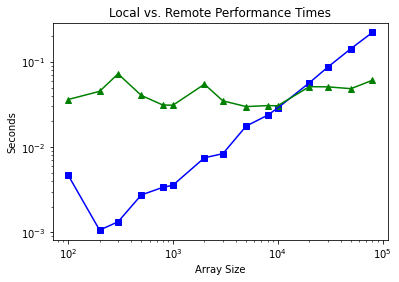

In [93]:
plt.xlabel('Array Size')
plt.ylabel('Seconds')
plt.xscale('log')
plt.yscale('log')
plt.plot(ns, local_durations, 'bs', ns, remote_durations, 'g^')
local_line = plt.plot(ns, local_durations, 'b')
remote_line = plt.plot(ns, remote_durations, 'g')
plt.setp(local_line, label='local')
plt.setp(remote_line, label='remote')

plt.title('Local vs. Remote Performance Times')
plt.show()

Let's find the crossing point:

In [94]:
i=0
while i < len(ns) and local_durations[i] < remote_durations[i]:
    i=i+1
print('The Ray times are faster starting at n = {:d}, local = {:6.3f} vs. remote = {:6.3f}'.format(
    ns[i], local_durations[i], remote_durations[i]))

The Ray times are faster starting at n = 20000, local =  0.057 vs. remote =  0.051


## How Distributed Task Management Works

> **Note:** If you just want to learn the Ray API, you can safely skip the rest of this lesson (notebook) for now. It continues the exploration of how Ray works internally, which we started in the previous lesson. However, you should come back to this material at some point, so you'll develop a better understanding of how Ray works.

At the end of the last lesson, we examined Ray task scheduling at a high-level, by watching the Ray Dashboard and analyzing the performance times. Now we'll walk through some images that show the process Ray follows to place tasks around a cluster. 

Assume we will invoke the `make_array` task twice, then invoke `add_arrays` to sum the returned NumPy arrays. Graphically, it looks as follows:
![Ray under the hood 1](../images/Ray-Cluster/Ray-Cluster.001.jpeg)

How does this get scheduled in a cluster? Here we'll assume a three-node cluster that has resources for running two Ray worker tasks per node (under powered compared to what we learned using Ray Dashboard last lesson!).
![Ray under the hood 2](../images/Ray-Cluster/Ray-Cluster.002.jpeg)

First, assume that the driver program is running on Node1. So it will invoke the local scheduler to schedule the three tasks.
![Ray under the hood 3](../images/Ray-Cluster/Ray-Cluster.003.jpeg)

Immediately the ids for the task futures are returned. The _Global Control Store_ tracks where every task is running and every object is stored in the local _Object Stores_.
![Ray under the hood 4](../images/Ray-Cluster/Ray-Cluster.004.jpeg)

Suppose the local scheduler has available capacity in the first worker on the same node. It schedules the first `make_array` task there.
![Ray under the hood 5](../images/Ray-Cluster/Ray-Cluster.005.jpeg)

It decides to schedule the second `make_array` task in a worker on node 2.
![Ray under the hood 6](../images/Ray-Cluster/Ray-Cluster.006.jpeg)

When the two tasks finish, they place their result objects in their local object stores.
![Ray under the hood 7](../images/Ray-Cluster/Ray-Cluster.007.jpeg)

Now `add_array` can be scheduled, because the two tasks it depends on are done. Let's suppose it gets scheduled in the second worker on Node 1.
![Ray under the hood 8](../images/Ray-Cluster/Ray-Cluster.008.jpeg)

The first object it needs is already on the same node, in the object store, so the `add_arrays` task can _read it directly from shared memory_. No copying is required to the worker's process space.
![Ray under the hood 9](../images/Ray-Cluster/Ray-Cluster.009.jpeg)

However, the second object is on a different node, so Ray copies it to the local object store. 
![Ray under the hood 10](../images/Ray-Cluster/Ray-Cluster.010.jpeg)

Now it can also be read from shared memory.
![Ray under the hood 11](../images/Ray-Cluster/Ray-Cluster.011.jpeg)

When `add_arrays` is finished, it writes its results to the local object store.
![Ray under the hood 12](../images/Ray-Cluster/Ray-Cluster.012.jpeg)

At this point, if the driver calls `ray.get(id3)`, it will return `obj3`.
![Ray under the hood 13](../images/Ray-Cluster/Ray-Cluster.013.jpeg)

Whew! Hopefully you have a better sense of what Ray does under the hood. Scheduling tasks on other nodes and copying objects between object stores is efficient, but incurs unavoidable network overhead.